The Markowitz model is a portfolio optimization model assisting in the selection of the most efficient portfolio by analyzing various possible portfolios of the given securities. Here, by choosing securities that do not "move" exactly together (i.e. by choosing stocks based on their correlations), the model shows how to reduce the risk when investing.

We start by retrieving (from Wikipedia) the composition of the S & P 500 and store it in a list

In [1]:
import pandas as pd

def get_sp_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    tables = pd.read_html(url)
    sp500_table = tables[0]
    sp500_tickers = sp500_table["Symbol"].tolist()
    sp500_tickers = [ticker.replace('.', '-') for ticker in sp500_tickers] # reformat the strings (e.g. BF.B -> BF-B) for yfinance
    return sp500_tickers

sp500_tickers = get_sp_tickers()
sp500_tickers[:5]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']

and use yahoo finance api to get the returns of the S & P 500 stocks over a given time period. We then compute the daily returns using Panda's .pct_change() method

In [2]:
import yfinance as yf

def get_returns(tickers, start_date, end_date):
    out = yf.download(tickers, start=start_date, end=end_date)
    out = out["Close"]
    out = out.pct_change() # daily returns: (price[i] - price[i - 1]) / price[i - 1]
    out = out.dropna() # drop the first row (full of nan by definition of the computation of the daily returns)
    return out

sp500_returns = get_returns(sp500_tickers, start_date="2024-01-01", end_date="2025-01-01")
sp500_returns.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  503 of 503 completed


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-09,-0.005156,0.003775,0.009188,0.003224,-0.004700,-0.002646,-0.004708,-0.016302,-0.005700,-0.003944,...,-0.009240,-0.000725,-0.005748,0.006908,-0.011054,-0.003506,-0.010005,-0.005922,0.002417,-0.006783
2024-07-10,0.013156,0.018804,0.000535,-0.004001,0.013873,-0.005102,-0.008790,-0.002597,0.027240,0.017424,...,0.003186,0.000363,-0.010028,0.002287,0.008834,0.020585,0.019817,0.010779,0.027186,-0.004304
2024-07-11,0.029511,-0.023221,0.010527,-0.038462,0.010965,-0.005128,0.013055,-0.012258,-0.019259,0.000311,...,0.014797,0.050036,0.008342,0.028332,0.011884,0.011222,0.002710,0.012067,0.013928,0.024497
2024-07-12,0.010778,0.013051,0.002178,0.005342,0.000384,-0.005155,0.042418,0.002546,0.020621,0.000467,...,0.008512,0.011050,0.014419,0.003698,0.000177,0.003989,0.013820,0.004621,-0.009533,0.007314
2024-07-15,-0.009226,0.016743,-0.004149,0.002998,-0.006849,0.006839,0.023307,0.011913,-0.003521,-0.013690,...,-0.003331,-0.008197,-0.014331,-0.019344,0.017127,-0.008091,-0.026045,-0.019873,0.007104,-0.005920


With these daily returns, we can compute the (estimated) expected returns of the S \& P 500 stocks (namely, by the mean of the daily returns). Moverover, given a set of weights and its associated portfolio, we can compute the (estimated) expected portfolio's returns.

Recall, by linearity of the expectation, that if
\begin{equation*}
    \Pi = \sum_{i = 1}^N w_i r_i
\end{equation*}
is our porfolio, with set of weigts $\lbrace w_i , 1 \leq i \leq N \rbrace$ and returns $\lbrace r_i, 1 \leq i \leq N \rbrace$ of stocks $\lbrace S_i, 1 \leq i \leq N \rbrace$, then
\begin{equation*}
    \mathbb{E}(\Pi) = \sum_{i = 1}^N w_i \mathbb{E}(r_i) = \begin{pmatrix} w_1 & \ldots & w_N \end{pmatrix} \begin{pmatrix} \mathbb{E}(r_1) \\
    \cdot \\ \cdot \\ \mathbb{E}(r_N) \end{pmatrix}.
\end{equation*}

In [3]:
import numpy as np

def portfolio_returns(weights, returns):
    sp_mean_returns = returns.mean().to_numpy()
    assert len(sp_mean_returns) == len(weights)
    return weights @ sp_mean_returns.T

def annualized_portfolio_returns(weights, returns):
    return portfolio_returns(weights, returns) * 250 # 250 days of trading

equal_weights = np.array([1/len(sp500_returns.columns)] * len(sp500_returns.columns))
portfolio_returns(equal_weights, sp500_returns), annualized_portfolio_returns(equal_weights, sp500_returns)

(0.0007090856922376328, 0.1772714230594082)

On the other hand, if the covariance matrix of the returns $\lbrace r_i, 1 \leq i \leq N \rbrace$ is
\begin{equation*}
    \Sigma = (\mathbf{Cov}(r_i, r_j))_{1 \leq i, j \leq N}
\end{equation*}
then
\begin{equation*}
    \mathbf{Var}(\Pi) = \mathbf{Var} \left( \sum_{i = 1}^N w_i r_i \right) = \begin{pmatrix} w_1 & \ldots & w_N \end{pmatrix} \Sigma \begin{pmatrix} w_1 \\
    \cdot \\ \cdot \\ w_N \end{pmatrix}.
\end{equation*}
Hence, given a set of weights and its associated portfolio, we can compute the variance in the (estimated) portfolio's returns.

In [4]:
def portfolio_var(weights, returns):
    sp_cov_returns = returns.cov().to_numpy()
    assert len(sp_cov_returns) == len(weights)
    return weights @ sp_cov_returns @ weights.T

def annualized_portfolio_var(weights, returns):
    return portfolio_var(weights, returns) * 250

def portfolio_std(weights, returns):
    return portfolio_var(weights, returns) ** (1/2)

def annualized_portfolio_std(weights, returns):
    return portfolio_std(weights, returns) * (250 ** (1/2))

equal_weights = np.array([1/len(sp500_returns.columns)] * len(sp500_returns.columns))
print(portfolio_var(equal_weights, sp500_returns), annualized_portfolio_var(equal_weights, sp500_returns))
print(portfolio_std(equal_weights, sp500_returns), annualized_portfolio_std(equal_weights, sp500_returns))

6.507624995173494e-05 0.016269062487933736
0.00806698518355742 0.1275502351543647


We now draw the efficient frontier by sampling random weights and plotting associated portfolio returns against portfolio stds. Note that, to get an interesting plot, we should restrict to the 2D case i.e. the case of two stocks.

Note that the efficient frontier draws a line connecting the "all in first stock" and the "all in second stock" portfolios.

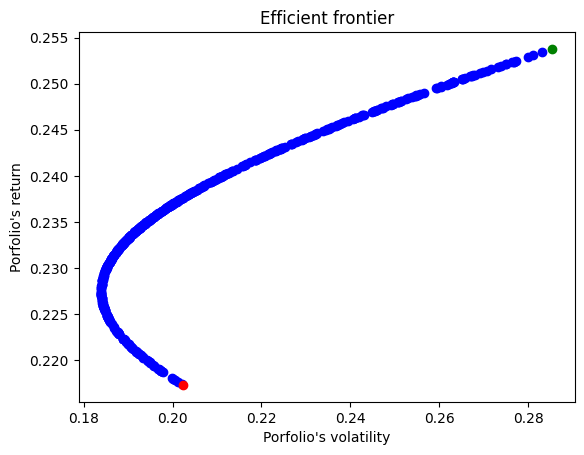

In [5]:
import matplotlib.pyplot as plt
import random
random.seed(1337)

def get_random_weights(returns):
    out = np.random.random(len(returns.columns))
    out /= out.sum()
    return out

two_stocks_returns = sp500_returns[["AAPL", "CAT"]] # Only consider Apple and Caterpilar stocks

returns = []
stds = []
weights = []

EPOCHS = 500
for i in range(EPOCHS):
    weight = get_random_weights(two_stocks_returns)
    weights.append(weight)
    returns.append(annualized_portfolio_returns(weight, two_stocks_returns))
    stds.append(annualized_portfolio_std(weight, two_stocks_returns))

plt.scatter(x = stds, y = returns, color = "blue")
plt.scatter(x = two_stocks_returns["AAPL"].std() * np.sqrt(250), y = two_stocks_returns["AAPL"].mean() * 250, color = "red")
plt.scatter(x = two_stocks_returns["CAT"].std() * np.sqrt(250), y = two_stocks_returns["CAT"].mean() * 250, color = "green")
plt.title("Efficient frontier")
plt.xlabel("Porfolio's volatility")
plt.ylabel("Porfolio's return")
plt.show()

For example, we can trace the minimal std portfolio's weights and adjust our position. More precisely, to obtain a minimal volatility portfolio in this Apple Caterpillar stocks example, one should invest roughly 72 % of his wealth on Catterpillar stocks and 28 % on Apple stocks.

In particular, investing everything on Apple would be for sure sub-optimal: for same risk, we can improve our portfolio's returns by roughly 1.7%

The same logic applies to the $N$ stocks case

In [6]:
minimal_std_weights = weights[stds.index(min(stds))]
minimal_std_weights

array([0.72252044, 0.27747956])